# Профильное тестовое задание ВК 

## Выполнил Сорочайкин Александр

# Загрузка данных и подключение библиотек

In [1]:
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint
import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data

,id,lat,lon,score
0,0,56.228300,43.945535,0.080523
1,1,56.834244,53.141543,0.104424
2,2,45.042299,41.990170,0.067615
3,3,59.849408,30.387762,0.088038
4,4,59.839643,30.304308,0.099686
...,...,...,...,...
3079,3079,55.674584,37.279505,0.531557
3080,3080,55.784909,49.188791,0.101631
3081,3081,55.118828,61.462996,0.125265
3082,3082,55.649052,37.533877,0.322601


In [4]:
features = pd.read_csv('features.csv')

In [5]:
features

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,59.837100,30.262701,0.411159,0.360032,0.350883,0.476389,0.373542,0.399907,0.397579,0.486442,...,0.041906,0.045916,0.085368,0.093044,0.014491,0.004091,0.043260,0.045916,0.060025,0.071592
1,59.935705,30.274201,0.500628,0.458489,0.522933,0.538892,0.482807,0.497257,0.541007,0.482956,...,0.041262,0.054171,0.066940,0.057510,0.007990,0.017897,0.042617,0.054171,0.047068,0.044251
2,59.929714,30.419863,0.450037,0.413593,0.445300,0.490658,0.403224,0.448099,0.516285,0.526028,...,0.044056,0.052290,0.126482,0.116896,0.006771,0.007329,0.045406,0.052290,0.088934,0.089945
3,56.111227,40.356119,0.160964,0.146153,0.301632,0.196871,0.157927,0.130723,0.246422,0.385300,...,0.043072,0.051181,0.042962,0.030555,0.010293,0.002216,0.044425,0.051181,0.030208,0.023510
4,56.233351,43.872728,0.102522,0.073835,0.270109,0.129343,0.106780,0.082463,0.201381,0.372377,...,0.047839,0.048137,0.135698,0.163684,0.009615,0.003579,0.049185,0.048137,0.095414,0.125946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,55.491370,37.308973,0.603469,0.427283,0.616920,0.787331,0.585380,0.572505,0.414610,0.439459,...,0.040365,0.049803,0.115943,0.086169,0.003115,0.002045,0.041721,0.049803,0.081524,0.066302
3697,55.752230,52.410299,0.111785,0.105864,0.223382,0.120843,0.107082,0.094998,0.371929,0.296617,...,0.254405,0.220451,0.510766,0.568700,0.401002,0.182376,0.445025,0.417609,0.599474,0.731169
3698,59.959671,30.304035,0.439632,0.425653,0.368872,0.489872,0.389968,0.428121,0.510918,0.351653,...,0.037683,0.046643,0.048304,0.046775,0.013543,0.009374,0.039043,0.046643,0.033964,0.035991
3699,47.239728,39.761925,0.189145,0.216876,0.354758,0.177157,0.151277,0.190271,0.238387,0.298505,...,0.052133,0.047801,0.065017,0.084407,0.001219,0.004602,0.053472,0.047801,0.045716,0.064947


# Обработка информации из таблицы features

Для корректной работы моделей машинного обучения, для каждого объекта из data необходимо получить больше признаков, нежели широта и долгота. Также, необходимо, чтобы эти признаки имели смысл и подходили к выбранному нами объекту. Используем для этого файл features.csv. Для каждого объекта из data хотим найти n объектов находящихся ближе всего к нему по координатам и взять медианное значение для каждого признака у этих n объектов 

In [6]:
# Количество ближайших строк для каждой строки в data
n_closest = 3

# Расчет расстояний между точками
distances = cdist(data[['lat', 'lon']], features[['lat', 'lon']], metric='euclidean')

# Находим индексы n самых близких строк
closest_indices = np.argsort(distances, axis=1)[:, :n_closest]

# Получаем ближайшие строки и вычисляем медиану признаков
closest_features = features.iloc[closest_indices.flatten()]
grouping_index = np.repeat(np.arange(len(data)), n_closest)
closest_features_grouped = closest_features.groupby(grouping_index).median()

# убираем колонки широты и долготы у новых признаков
closest_features_grouped.drop(['lat', 'lon'], axis=1,inplace=True)

# Объединяем признаки с исходными данными
data_with_features = pd.concat([data, closest_features_grouped], axis=1)

In [7]:
data_with_features

,id,lat,lon,score,0,1,2,3,4,5,...,353,354,355,356,357,358,359,360,361,362
0,0,56.228300,43.945535,0.080523,0.150903,0.144008,0.270909,0.165117,0.137542,0.135348,...,0.040666,0.046995,0.127040,0.095402,0.008532,0.006988,0.042022,0.046995,0.089327,0.073406
1,1,56.834244,53.141543,0.104424,0.094093,0.096425,0.208443,0.089489,0.106608,0.085787,...,0.248620,0.247200,0.454053,0.455990,0.446641,0.207602,0.396096,0.390619,0.589031,0.650977
2,2,45.042299,41.990170,0.067615,0.151723,0.148761,0.329598,0.167240,0.145691,0.138382,...,0.119155,0.125913,0.285129,0.221562,0.125406,0.056588,0.282946,0.303173,0.435053,0.449764
3,3,59.849408,30.387762,0.088038,0.420841,0.309185,0.343971,0.509889,0.406718,0.400816,...,0.047290,0.056366,0.110967,0.106399,0.016387,0.005454,0.048637,0.056366,0.078025,0.081868
4,4,59.839643,30.304308,0.099686,0.398031,0.357796,0.444924,0.454000,0.376711,0.374464,...,0.032855,0.043981,0.076760,0.078806,0.028440,0.008693,0.034222,0.043981,0.053973,0.060637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079,3079,55.674584,37.279505,0.531557,0.628328,0.508291,0.396978,0.788273,0.614644,0.588321,...,0.053256,0.064378,0.101665,0.097760,0.009345,0.006988,0.054594,0.064378,0.071484,0.075221
3080,3080,55.784909,49.188791,0.101631,0.170702,0.198607,0.328156,0.157701,0.141521,0.160606,...,0.040777,0.051746,0.052035,0.072731,0.008261,0.006988,0.042133,0.051746,0.036588,0.055963
3081,3081,55.118828,61.462996,0.125265,0.125451,0.085514,0.276783,0.137704,0.127110,0.106288,...,0.059907,0.063839,0.118491,0.113721,0.020585,0.005284,0.061235,0.063839,0.087714,0.087502
3082,3082,55.649052,37.533877,0.322601,0.663058,0.629910,0.590677,0.773598,0.582316,0.643341,...,0.027110,0.027882,0.104870,0.096486,0.005011,0.001193,0.028485,0.027882,0.073738,0.074240


# Предобработка данных

## Обработка выбросов

In [8]:
def anomal_index(df):
    # Настройка гиперпараметров с использованием RandomizedSearchCV
    param_dist = {'n_estimators': randint(50, 200),
                  'max_samples': ['auto', 0.5, 0.75],
                  'max_features': [1.0, 0.5, 0.75]}
    
    # Указание ROC-AUC в качестве основной метрики качества
    clf = RandomizedSearchCV(IsolationForest(random_state=42), param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1)
    clf.fit(df)
    
    # Поиск оптимальных гиперпараметров
    best_params = clf.best_params_
    
    # Создание экземпляра IsolationForest с оптимальными параметрами
    best_clf = IsolationForest(**best_params, random_state=42)
    
    # Обучение модели на данных
    best_clf.fit(df)
    
    # Предсказание выбросов
    return best_clf.predict(df) == 1

In [9]:
not_anomal_index = anomal_index(data_with_features)
data_with_features = data_with_features[not_anomal_index]

/Users/Work/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Work/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/Work/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Work/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_para

In [10]:
data_with_features.reset_index(inplace = True, drop = True)

## Обработка числовых фич

In [11]:
one_thing = []
for column in data_with_features.columns:
    if len(data_with_features[column].unique())/len(data_with_features[column]) < 0.5:
        data_with_features[column] = data_with_features[column].astype('category')
    if len(data_with_features[column].unique()) == 1:
        one_thing.append(column)

/var/folders/6g/szzj7pj13h50gcdj6z23qjmr0000gp/T/ipykernel_28230/3619226932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_features[column] = data_with_features[column].astype('category')


### Удаляем фичи, у которых ровно 1 уникальное значение

In [12]:
data_with_features.drop(one_thing, axis = 1, inplace = True)

/var/folders/6g/szzj7pj13h50gcdj6z23qjmr0000gp/T/ipykernel_28230/22622869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_features.drop(one_thing, axis = 1, inplace = True)


### Удаляем фичи с большой кореляцией

In [13]:
# Удаление фичей, которые коррелируют друг с другом больше, чем на 0.9
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [14]:
clean_df = data_with_features.copy()
nan_percentage = (clean_df == 0).mean()
cols_to_drop = list(nan_percentage[nan_percentage > 0.95].index)

ignore_features = ['id','score']+cols_to_drop
ignore_features = ['id','score']
clean_df = clean_df.drop(columns=ignore_features)

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False), columns=clean_df.columns, index=clean_df.columns)

In [15]:
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.95)
len(corr_feats)

Get correlated features: 100%|█████████████| 360/360 [00:00<00:00, 12289.80it/s]


226

In [16]:
df_no_corr = clean_df.drop(columns=corr_feats)

In [17]:
print("Было:", data_with_features.shape)
print("Стало:", df_no_corr.shape)

Было: (2995, 362)
Стало: (2995, 134)


### Получение самых важных фичей с помощью случайного леса

In [18]:
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(df_no_corr, data_with_features['score'])

RandomForestRegressor(random_state=42)

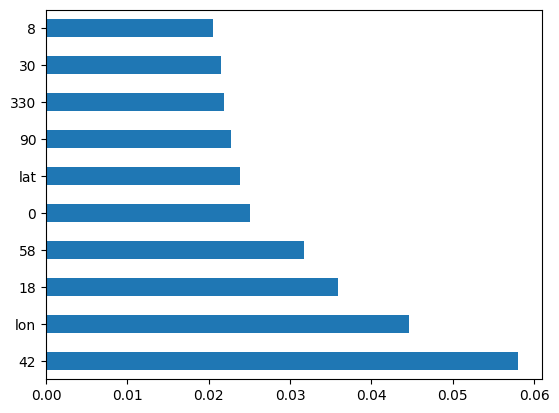

In [19]:
feature_importances = pd.Series(forest.feature_importances_, index=df_no_corr.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

In [20]:
sfm = SelectFromModel(forest, threshold=0.02)  # Выберите подходящий порог
sfm.fit(df_no_corr, data_with_features['score'])
X_selected = sfm.transform(df_no_corr)

In [21]:
selected_features = df_no_corr.columns[sfm.get_support()]
df_no_corr = pd.DataFrame(data=X_selected, columns=selected_features)

In [22]:
print("Было:", data_with_features.shape)
print("Стало:", df_no_corr.shape)

Было: (2995, 362)
Стало: (2995, 10)


# Обучение модели ML

### Сохраним название оставленных столбцов, для тестовых данных

In [23]:
# Создаем DataFrame из списка подходящих столбцов
columns_df = pd.DataFrame({'Column_Name': df_no_corr.columns})

# Сохраняем список подходящих столбцов в файл
columns_df.to_csv('suitable_columns.csv', index=False)

### Обработка данных

In [24]:
X = df_no_corr
y = data_with_features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
y.describe()

count    2995.000000
mean        0.134509
std         0.118419
min         0.000000
25%         0.077973
50%         0.094967
75%         0.118134
max         0.945558
Name: score, dtype: float64

### Случайный лес

In [26]:
# Создание модели случайного леса
model = RandomForestRegressor(n_estimators=100)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)

# Вычисление MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.04448267668378112


In [27]:
y_train_pred = model.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
print("Mean Absolute Error (Train):", mae_train)

Mean Absolute Error (Train): 0.017102529697444652


# Сохраняем модель для использования в скрипте решения

In [28]:
# Сохраняем модель в файл trained_model.pkl
import joblib
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']